In [6]:
import open3d as o3d
import numpy as np
import cv2, PIL
from cv2 import aruco
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import argparse
import imutils
import sys
%matplotlib nbagg

### Depth Image to Point Cloud Visualization with Open3d

In [7]:
class AzureKinect:
    def __init__(self):
        self.config = o3d.io.AzureKinectSensorConfig()
        self.device = 0
        self.align_depth_to_color = 1

    def start(self):
        self.sensor = o3d.io.AzureKinectSensor(self.config)
        if not self.sensor.connect(self.device):
            raise RuntimeError('Failed to connect to sensor')

    def frames(self):
            while 1:
                rgbd = self.sensor.capture_frame(self.align_depth_to_color)
                if rgbd is None:
                    continue
                color,depth = np.asarray(rgbd.color).astype(np.uint8),np.asarray(rgbd.depth).astype(np.float32) / 1000.0
                return color, depth

In [8]:
cam = AzureKinect()
cam.start()
color, depth = cam.frames()
intrinsic = o3d.camera.PinholeCameraIntrinsic(1280, 720, 601.1693115234375, 600.85931396484375, 637.83624267578125, 363.8018798828125)
depth = o3d.geometry.Image(depth)
img = o3d.geometry.Image(color)
rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(img, depth, depth_scale=1.0, convert_rgb_to_intensity=False)
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsic)
o3d.visualization.draw_geometries([pcd])

[Open3D INFO] AzureKinectSensor::Connect
[Open3D INFO] sensor_index 0
[Open3D INFO] Serial number: 000276693112
[Open3D INFO] Firmware build: Rel
[Open3D INFO] > Color: 1.6.102
[Open3D INFO] > Depth: 1.6.75[6109.7]


### Aruco Marker Detection with OpenCV

Generate the Aruco marker dictionary

<IPython.core.display.Javascript object>


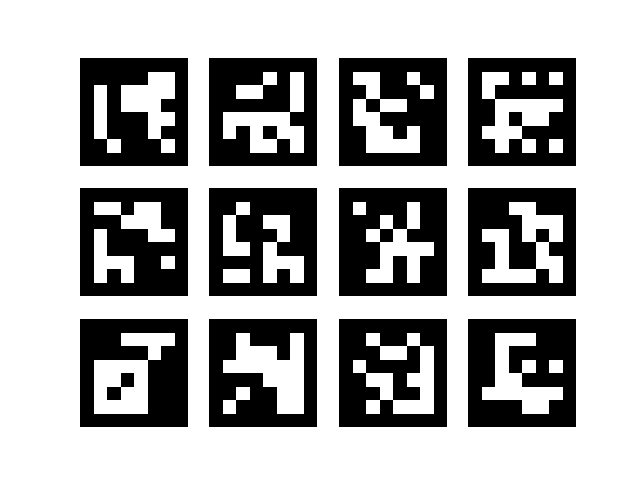

In [2]:
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)

fig = plt.figure()
nx = 4
ny = 3
for i in range(1, nx*ny+1):
    ax = fig.add_subplot(ny,nx, i)
    img = aruco.drawMarker(aruco_dict,i, 700)
    plt.imshow(img, cmap = mpl.cm.gray, interpolation = "nearest")
    ax.axis("off")

plt.savefig("./markers.pdf")
plt.show()

Print and take a picture

<IPython.core.display.Javascript object>


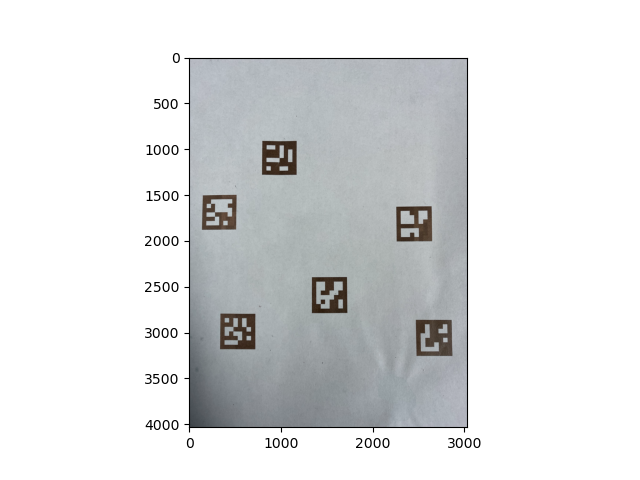

In [3]:
frame = cv2.imread("./aruco_print.jpg")
plt.figure()
plt.imshow(frame)
plt.show()

Post processing

In [4]:
%%time
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
aruco_dict = aruco.Dictionary_get(aruco.DICT_6X6_250)
parameters =  aruco.DetectorParameters_create()
corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, aruco_dict, parameters=parameters)
frame_markers = aruco.drawDetectedMarkers(frame.copy(), corners, ids)

CPU times: user 262 ms, sys: 123 ms, total: 385 ms
Wall time: 167 ms


Display results

<IPython.core.display.Javascript object>


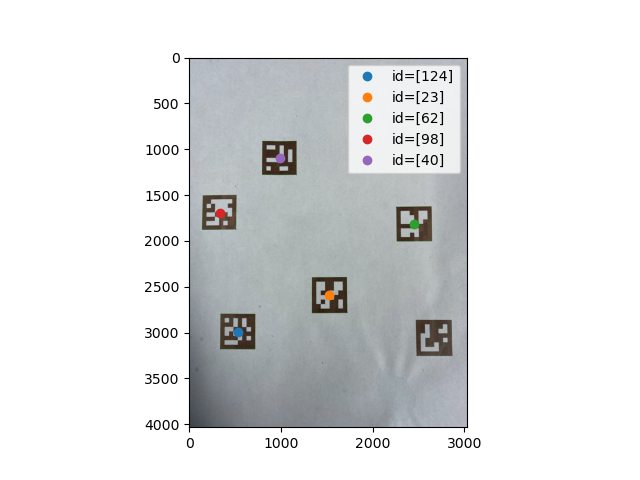

In [14]:
plt.figure()
plt.imshow(frame_markers)
for i in range(len(ids)):
    c = corners[i][0]
    plt.plot([c[:, 0].mean()], [c[:, 1].mean()], "o", label = "id={0}".format(ids[i]))
plt.legend()
plt.show()